### Improvements 
## IMP: Fitrar por la surface--remove events that move out of the surface on the first 3 secons
1) Remove blinks and interpolate values using cubic splines
2) Blank filtering of data---Done-- maibe explore other filter
3) Frequency analysis of the signal??
4) Remove trials with z scores over [2,-2]
5) Convert time to seconds
6) Open PLA file
7) Statistics of signal ¿How to compare surprise signals?
8) Amplitud, velocidad de cambio
9) Cut the whole signal of interest from the beggining
10) Fitrar por la surface


In [7]:
import pandas as pd 
import numpy as np
from pathlib import Path
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
import sys
sys.path.append('../')
import commons as cm
from data_curation import Normalization
nm=Normalization()

recording_location = r"C:\Users\Bolo\Desktop\Laboratorio\incipit\data\pupil_emotibit\ES0001_S002_PC_EM\data\pupil_labs\002"
image_location=r"../../../../data/pupil_emotibit/ES0001_S002_PC_EM/images_order"

def print_file_structure(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in sorted(files):
            print(f'{subindent}{f}')
# print_file_structure(recording_location)


exported_pupil_csv = os.path.join(recording_location, 'exports', '000', 'pupil_positions.csv')
pupil_pd_frame = pd.read_csv(exported_pupil_csv)
exported_gaze_csv = os.path.join(recording_location, 'exports', '000', 'gaze_positions.csv')
gaze_pd_frame = pd.read_csv(exported_gaze_csv)
annotations_csv = os.path.join(recording_location, 'exports', '000', 'annotations.csv')
annotations_pd = pd.read_csv(annotations_csv)
surface_gaze_csv = os.path.join(recording_location, 'exports', '000', 'surfaces','gaze_positions_on_surface_Surface_1.csv')
surfaces_pd_frame = pd.read_csv(surface_gaze_csv)

In [8]:
pupil_pd_frame['join_index']=np.nan
surfaces_pd_frame['join_index']=np.nan
surfaces_pd_frame


,world_timestamp,world_index,gaze_timestamp,x_norm,y_norm,x_scaled,y_scaled,on_surf,confidence,join_index
0,14963.529049,0,14963.464168,0.390105,-0.042263,0.390105,-0.042263,False,0.990000,NaN
1,14963.529049,0,14963.468149,0.385552,-0.102956,0.385552,-0.102956,False,0.990000,NaN
2,14963.529049,0,14963.472153,0.379080,-0.151352,0.379080,-0.151352,False,0.990000,NaN
3,14963.529049,0,14963.476132,0.373581,-0.219004,0.373581,-0.219004,False,0.990000,NaN
4,14963.529049,0,14963.480131,0.366127,-0.282971,0.366127,-0.282971,False,0.990000,NaN
...,...,...,...,...,...,...,...,...,...,...
159422,15616.684612,38927,15616.689655,0.321895,0.354199,0.321895,0.354199,True,0.937488,NaN
159423,15616.700605,38928,15616.693664,0.296020,0.369735,0.296020,0.369735,True,0.913507,NaN
159424,15616.700605,38928,15616.697709,0.285577,0.378988,0.285577,0.378988,True,0.913507,NaN
159425,15616.700605,38928,15616.701701,0.277222,0.380498,0.277222,0.380498,True,0.914925,NaN


### Filter data that is inside the surface
#### Due to the fact that te gaze timesatmp of the surface is obtained by combining data from both pupils we cant just merge by the timestamp. We have to read and duplicate values

In [9]:
pupil_list=[]
surface_list=[]
ref_col_gaze=surfaces_pd_frame.columns.get_indexer(['gaze_timestamp'])[0]
ref_col_index=surfaces_pd_frame.columns.get_indexer(['join_index'])[0]

for row in range(surfaces_pd_frame.shape[0]-1):
        ini_value=surfaces_pd_frame.iloc[row,ref_col_gaze]
        end_value=surfaces_pd_frame.iloc[row+1,ref_col_gaze]
        # print(ini_value,end_value)
        index_1=(pupil_pd_frame['pupil_timestamp']>=ini_value)&(pupil_pd_frame['pupil_timestamp']< end_value)
          
        pupil_pd_frame.loc[index_1,['join_index']]=row
        surfaces_pd_frame.iloc[row,ref_col_index]=row
        


In [10]:
pupil_pd_frame.head()

,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,join_index
0,14963.532079,0,0,0.967541,0.384912,0.601413,32.496613,pye3d 0.3.0 real-time,73.903172,76.528654,...,-0.853685,1.690155,1.552422,-2.118296,114.033851,78.141415,165.699953,165.699953,0.0,16.0
1,14963.532079,0,0,0.967541,0.384946,0.601443,32.499603,2d c++,73.909576,76.522873,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0
2,14963.532146,0,1,1.000000,0.305218,0.387613,36.263992,2d c++,58.601776,117.578255,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0
3,14963.532146,0,1,1.000000,0.305221,0.387696,36.252590,pye3d 0.3.0 real-time,58.602380,117.562393,...,-0.782323,1.777172,1.738252,-2.225184,109.252397,126.930874,174.366655,174.366655,0.0,17.0
4,14963.540161,1,0,0.968023,0.385050,0.601268,32.357941,pye3d 0.3.0 real-time,73.929623,76.556600,...,-0.854217,1.682928,1.554692,-2.117337,114.033851,78.141415,165.699953,165.699953,0.0,18.0


In [15]:
final_df=pd.merge(pupil_pd_frame, surfaces_pd_frame, on="join_index", how="left",suffixes=['','_sur'])
final_df.head()

,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,join_index,world_timestamp,world_index_sur,gaze_timestamp,x_norm,y_norm,x_scaled,y_scaled,on_surf,confidence_sur
0,14963.532079,0,0,0.967541,0.384912,0.601413,32.496613,pye3d 0.3.0 real-time,73.903172,76.528654,...,16.0,14963.529049,0,14963.528147,0.354906,-0.409452,0.354906,-0.409452,False,0.983771
1,14963.532079,0,0,0.967541,0.384946,0.601443,32.499603,2d c++,73.909576,76.522873,...,16.0,14963.529049,0,14963.528147,0.354906,-0.409452,0.354906,-0.409452,False,0.983771
2,14963.532146,0,1,1.000000,0.305218,0.387613,36.263992,2d c++,58.601776,117.578255,...,17.0,14963.529049,0,14963.532113,0.356602,-0.408369,0.356602,-0.408369,False,0.983771
3,14963.532146,0,1,1.000000,0.305221,0.387696,36.252590,pye3d 0.3.0 real-time,58.602380,117.562393,...,17.0,14963.529049,0,14963.532113,0.356602,-0.408369,0.356602,-0.408369,False,0.983771
4,14963.540161,1,0,0.968023,0.385050,0.601268,32.357941,pye3d 0.3.0 real-time,73.929623,76.556600,...,18.0,14963.529049,0,14963.536154,0.357338,-0.411519,0.357338,-0.411519,False,0.984012


### Cut all data by annotations of interest

In [76]:
pupil_pd_frame=final_df
from IPython.display import display

event_initial=annotations_pd['label'].values[0]
event_final=annotations_pd['label'].values[-1]

initial_anotation,_,_=cm.extract_annotations_timestamps(event_initial,'label',annotations_pd)
end_anotation=annotations_pd.iloc[-1]
display(initial_anotation)
display(end_anotation)

pupil_pd_frame=cm.filter_rows_by_temporal_values(
         dataframe=pupil_pd_frame,
         time_column='pupil_timestamp',
         ini_value=initial_anotation['timestamp'].values[0],
         end_value=end_anotation['timestamp']
         )

,index,timestamp,label,duration,timestamp_s
0,5377,15054.349196,blank_0,NaN,0.0


index                    34669
timestamp         15545.169033
label          EndOfExperiment
duration                   NaN
timestamp_s         490.819838
Name: 147, dtype: object

## Extract the data
Extracting pupil 3d data for analysis

In [77]:
from IPython.display import display

confidence_thr=1
 
# filter for 3d data
detector_3d_data = pupil_pd_frame[pupil_pd_frame.method == 'pye3d 0.3.0 real-time']

pupil_left_eye_interpolated=detector_3d_data.loc[(pupil_pd_frame['eye_id']==1)& (pupil_pd_frame['on_surf']==True)]
pupil_right_eye_interpolated=detector_3d_data.loc[(pupil_pd_frame['eye_id']==0)& (pupil_pd_frame['on_surf']==True)]

left_conf_index=(pupil_left_eye_interpolated['confidence']>=confidence_thr).values
right_conf_index=(pupil_right_eye_interpolated['confidence']>=confidence_thr).values

pupil_left_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==1) & (pupil_pd_frame['confidence']>=confidence_thr)]
pupil_right_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==0) & (pupil_pd_frame['confidence']>=confidence_thr)]

blinks_left_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==1) & (pupil_pd_frame['confidence']< confidence_thr)]
blinks_right_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==0) & (pupil_pd_frame['confidence']< confidence_thr)]

pupil_left_eye_surface=detector_3d_data.loc[(pupil_pd_frame['eye_id']==1) & (pupil_pd_frame['confidence']>=confidence_thr)& (pupil_pd_frame['on_surf']==True)]
pupil_right_eye_surface=detector_3d_data.loc[(pupil_pd_frame['eye_id']==0) & (pupil_pd_frame['confidence']>=confidence_thr)& (pupil_pd_frame['on_surf']==True)]

pupil_left_eye_surface=detector_3d_data.loc[(pupil_pd_frame['eye_id']==1) & (pupil_pd_frame['confidence']>=confidence_thr)& (pupil_pd_frame['on_surf']==True)]
pupil_right_eye_surface=detector_3d_data.loc[(pupil_pd_frame['eye_id']==0) & (pupil_pd_frame['confidence']>=confidence_thr)& (pupil_pd_frame['on_surf']==True)]

blinks_left_eye_surface=detector_3d_data.loc[(pupil_pd_frame['eye_id']==1) & (pupil_pd_frame['confidence']< confidence_thr)& (pupil_pd_frame['on_surf']==True)]
blinks_right_eye_surface=detector_3d_data.loc[(pupil_pd_frame['eye_id']==0) & (pupil_pd_frame['confidence']< confidence_thr)& (pupil_pd_frame['on_surf']==True)]

out_surface=detector_3d_data.loc[(pupil_pd_frame['eye_id']==1) & (pupil_pd_frame['confidence']>=confidence_thr)& (pupil_pd_frame['on_surf']==True)]

In [78]:
pupil_left_eye_interpolated['diameter_3d_cubic']=cm.cubic_siplne_interpolation(
                                                x=pupil_left_eye_interpolated.loc[left_conf_index,['pupil_timestamp']].values.flatten(),
                                                y= pupil_left_eye_interpolated.loc[left_conf_index,['diameter_3d']].values.flatten(),
                                                x_interpolate=pupil_left_eye_interpolated['pupil_timestamp'].values.flatten()
                                                )

pupil_right_eye_interpolated['diameter_3d_cubic']=cm.cubic_siplne_interpolation(
                                                x=pupil_right_eye_interpolated.loc[right_conf_index,['pupil_timestamp']].values.flatten(),
                                                y= pupil_right_eye_interpolated.loc[right_conf_index,['diameter_3d']].values.flatten(),
                                                x_interpolate=pupil_right_eye_interpolated['pupil_timestamp'].values.flatten()
                                                )


filter_events=annotations_pd['label'].str.contains('Asset') | annotations_pd['label'].str.contains('Control') | annotations_pd['label'].str.contains('Surprise')
filter_assets=annotations_pd['label'].str.contains('Asset') 

filter_events_surprise= annotations_pd['label'].str.contains('Surprise')
filter_events_blank= annotations_pd['label'].str.contains('blank')

print("eye0 (right eye) data:")
display(pupil_right_eye[['pupil_timestamp', 'eye_id', 'confidence', 'norm_pos_x', 'norm_pos_y', 'diameter_3d']].head(10))

print("eye1 data (left eye) data:")
display(pupil_left_eye[['pupil_timestamp', 'eye_id', 'confidence', 'norm_pos_x', 'norm_pos_y', 'diameter_3d']].head(10))


eye0 (right eye) data:


C:\Users\Bolo\AppData\Local\Temp\ipykernel_24720\3641935838.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_left_eye_interpolated['diameter_3d_cubic']=cm.cubic_siplne_interpolation(
C:\Users\Bolo\AppData\Local\Temp\ipykernel_24720\3641935838.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_right_eye_interpolated['diameter_3d_cubic']=cm.cubic_siplne_interpolation(


,pupil_timestamp,eye_id,confidence,norm_pos_x,norm_pos_y,diameter_3d
43421,15054.356030,0,1.0,0.376038,0.496568,3.470677
43425,15054.364049,0,1.0,0.376093,0.496178,3.490731
43429,15054.372089,0,1.0,0.376334,0.496036,3.500846
43432,15054.380040,0,1.0,0.375887,0.496698,3.512908
43436,15054.388039,0,1.0,0.376280,0.496136,3.489541
43440,15054.396023,0,1.0,0.376136,0.496511,3.510092
43444,15054.404063,0,1.0,0.376134,0.496979,3.473783
43449,15054.412031,0,1.0,0.376466,0.497002,3.515241
43453,15054.420031,0,1.0,0.376436,0.496564,3.528533
43459,15054.432050,0,1.0,0.376597,0.496109,3.503948


eye1 data (left eye) data:


,pupil_timestamp,eye_id,confidence,norm_pos_x,norm_pos_y,diameter_3d
43419,15054.351944,1,1.0,0.345204,0.499847,3.267825
43423,15054.359981,1,1.0,0.344552,0.499894,3.276994
43427,15054.367954,1,1.0,0.344695,0.499790,3.285312
43431,15054.375973,1,1.0,0.344494,0.499855,3.280704
43434,15054.383926,1,1.0,0.344508,0.499846,3.281696
43438,15054.392082,1,1.0,0.344462,0.499776,3.280453
43442,15054.400085,1,1.0,0.344494,0.499852,3.280318
43447,15054.408107,1,1.0,0.344787,0.499655,3.274949
43450,15054.416066,1,1.0,0.344811,0.499833,3.295623
43455,15054.424111,1,1.0,0.344733,0.499816,3.269333


In [79]:
pupil_left_eye_interpolated.head()

,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,world_timestamp,world_index_sur,gaze_timestamp,x_norm,y_norm,x_scaled,y_scaled,on_surf,confidence_sur,diameter_3d_cubic
43419,15054.351944,5378,1,1.0,0.345204,0.499847,33.733093,pye3d 0.3.0 real-time,66.279181,96.029377,...,15053.893068,5349,15053.898041,0.496598,0.568213,0.496598,0.568213,True,1.0,3.267825
43423,15054.359981,5378,1,1.0,0.344552,0.499894,33.820506,pye3d 0.3.0 real-time,66.154009,96.020414,...,15053.893068,5349,15053.898041,0.496598,0.568213,0.496598,0.568213,True,1.0,3.276994
43427,15054.367954,5379,1,1.0,0.344695,0.499790,33.909798,pye3d 0.3.0 real-time,66.181473,96.040395,...,15053.893068,5349,15053.898041,0.496598,0.568213,0.496598,0.568213,True,1.0,3.285312
43431,15054.375973,5379,1,1.0,0.344494,0.499855,33.859840,pye3d 0.3.0 real-time,66.142770,96.027789,...,15053.893068,5349,15053.898041,0.496598,0.568213,0.496598,0.568213,True,1.0,3.280704
43434,15054.383926,5380,1,1.0,0.344508,0.499846,33.871061,pye3d 0.3.0 real-time,66.145470,96.029615,...,15053.893068,5349,15053.898041,0.496598,0.568213,0.496598,0.568213,True,1.0,3.281696


df to analyse


In [80]:
pupil_left_eye=pupil_left_eye_surface
pupil_right_eye=pupil_right_eye_surface

blinks_left_eye=blinks_left_eye_surface
blinks_right_eye=blinks_right_eye_surface

In [81]:
import json
f = open(recording_location+'/info.player.json')
data = json.load(f)
time_whole_recording=data['duration_s']
time_roi_left=abs(pupil_left_eye['pupil_timestamp'].values[-1]-pupil_left_eye['pupil_timestamp'].values[0])
time_roi_right=abs(pupil_right_eye['pupil_timestamp'].values[-1]-pupil_right_eye['pupil_timestamp'].values[0])

pupil_sampling_freq_left=(pupil_left_eye.shape[0]+blinks_left_eye.shape[0])/time_roi_left
pupil_sampling_freq_right=(pupil_right_eye.shape[0]+blinks_right_eye.shape[0])/time_roi_right 
print('sampling frequency for right eye is {}'.format(pupil_sampling_freq_right)) 
print('sampling frequency for left eye is {}'.format(pupil_sampling_freq_left)) 

# Closing file
f.close()


sampling frequency for right eye is 122.75275489655
sampling frequency for left eye is 122.57350640639294


##  Explore blinks and Asses data quality, are there many regions with data gaps? 


### Asses data quality

In [82]:
total_blinks_left=blinks_left_eye.shape[0]/pupil_sampling_freq_left
total_blinks_right=blinks_right_eye.shape[0]/pupil_sampling_freq_right
print(f'Total blinks time left {total_blinks_left:.2f}s and right {total_blinks_right:.2f}s of a total of {time_roi_left:.2f}s left and {time_roi_right:.2f}s right')
print(f'Total blinks time left {total_blinks_left/time_roi_left:.2%} ')
print(f'Total blinks time right {total_blinks_right/time_roi_right:.2%} ')


Total blinks time left 15.64s and right 55.80s of a total of 490.82s left and 490.81s right
Total blinks time left 3.19% 
Total blinks time right 11.37% 


## Put timestamp data in seconds


In [83]:
pupil_left_eye['timestamp_s']=pupil_left_eye['pupil_timestamp']-pupil_left_eye['pupil_timestamp'].values[0]
pupil_left_eye['timestamp_s']

pupil_right_eye['timestamp_s']=pupil_right_eye['pupil_timestamp']-pupil_right_eye['pupil_timestamp'].values[0]
pupil_right_eye['timestamp_s']

annotations_pd['timestamp_s']=annotations_pd['timestamp']-annotations_pd['timestamp'].values[0]


C:\Users\Bolo\AppData\Local\Temp\ipykernel_24720\2321012662.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_left_eye['timestamp_s']=pupil_left_eye['pupil_timestamp']-pupil_left_eye['pupil_timestamp'].values[0]
C:\Users\Bolo\AppData\Local\Temp\ipykernel_24720\2321012662.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_right_eye['timestamp_s']=pupil_right_eye['pupil_timestamp']-pupil_right_eye['pupil_timestamp'].values[0]


### View Raw data

Text(0.5, 1.0, 'Both eyes')

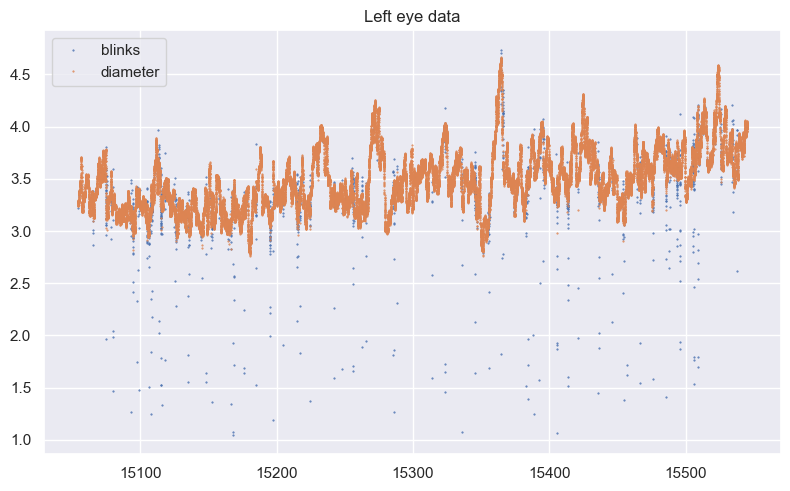

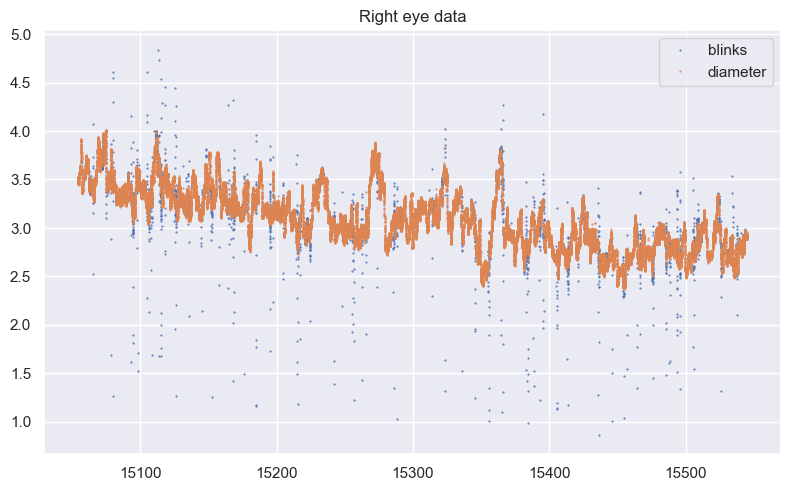

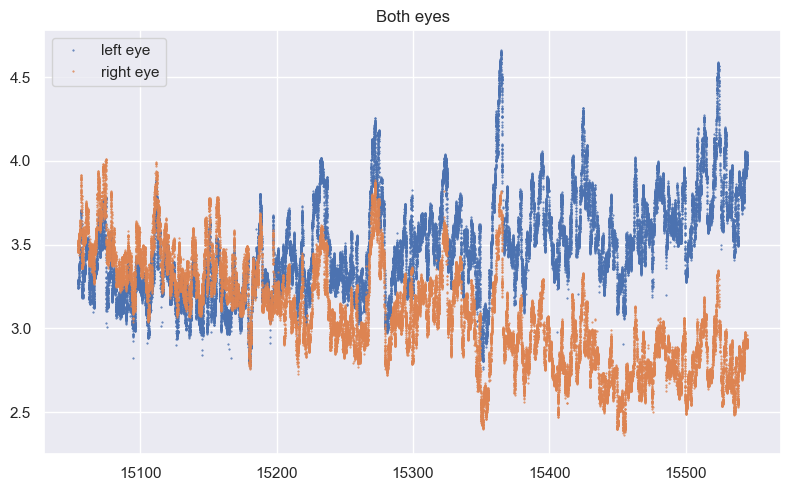

In [84]:
%matplotlib inline
#for left eye
fig, ax=plt.subplots(1,1)
ax.plot(blinks_left_eye['pupil_timestamp'],blinks_left_eye['diameter_3d'],'.',markersize=1)
ax.plot(pupil_left_eye['pupil_timestamp'],pupil_left_eye['diameter_3d'],'.',markersize=1)
ax.legend(['blinks','diameter'])    
fig.set_size_inches((9.5, 5.5))
ax.set_title('Left eye data')

#for right eye
fig, ax=plt.subplots(1,1)
ax.plot(blinks_right_eye['pupil_timestamp'],blinks_right_eye['diameter_3d'],'.',markersize=1)
ax.plot(pupil_right_eye['pupil_timestamp'],pupil_right_eye['diameter_3d'],'.',markersize=1)
ax.legend(['blinks','diameter'])    
fig.set_size_inches((9.5, 5.5))
ax.set_title('Right eye data')

fig, ax=plt.subplots(1,1)
ax.plot(pupil_left_eye['pupil_timestamp'],pupil_left_eye['diameter_3d'],'.',markersize=1)
ax.plot(pupil_right_eye['pupil_timestamp'],pupil_right_eye['diameter_3d'],'.',markersize=1)
ax.legend(['left eye','right eye'])    
fig.set_size_inches((9.5, 5.5))
ax.set_title('Both eyes')



### Do cubic splines aeasily, in the future use a better blink detection algorithm

In [85]:
%matplotlib qt


fig, ax = plt.subplots(2,1,figsize=(15, 8))
ax[0].plot(pupil_left_eye_interpolated['pupil_timestamp'], pupil_left_eye_interpolated['diameter_3d'], 'o', label='data')
ax[0].plot(pupil_left_eye_interpolated['pupil_timestamp'], pupil_left_eye_interpolated['diameter_3d_cubic'],'.', label="interpolated")
ax[0].legend(loc='lower right', ncol=2)
ax[0].set_title('left eye')
ax[0].set_xlabel('sample')
ax[0].set_ylabel('diameter (mm)')


ax[1].plot(pupil_right_eye_interpolated['pupil_timestamp'], pupil_right_eye_interpolated['diameter_3d'], 'o', label='data')
ax[1].plot(pupil_right_eye_interpolated['pupil_timestamp'], pupil_right_eye_interpolated['diameter_3d_cubic'],'.', label="interpolated")
ax[1].legend(loc='lower right', ncol=2)
ax[1].set_title('right eye')
ax[1].set_xlabel('sample')
ax[1].set_ylabel('diameter (mm)')
fig.tight_layout()

usaing smooting splines

## 

In [87]:
time_col_str='timestamp_s'
signal_str='diameter_3d'
sns.set_theme()

%matplotlib qt
fig1, ax=plt.subplots(1,)
ax.plot(pupil_left_eye[time_col_str],pupil_left_eye[signal_str],'.')
for  index, row in annotations_pd[filter_events].iterrows():
    plt.axvline(row[time_col_str], color='r', label='axvline - full height')
    ax.text((row[time_col_str]),3,row['label'])
ax.set_title('pupil diameter and events')    
ax.set_xlabel(f'{time_col_str}')
ax.set_ylabel(f'{signal_str}')
fig1.set_size_inches((18, 5.5))

fig2, ax=plt.subplots(1)
ax.plot(pupil_left_eye[time_col_str],pupil_left_eye[signal_str],'.')
for  index, row in annotations_pd[filter_events_surprise].iterrows():
    plt.axvline(row[time_col_str], color='r', label='axvline - full height')
    ax.text((row[time_col_str]),3,row['label'])
ax.set_title('pupil diameter and events')    
ax.set_xlabel(f'{time_col_str}')
ax.set_ylabel(f'{signal_str}')
fig2.set_size_inches((18, 5.5))

# plt.tight_layout()

## Apply normalizations


### Create different normalization columns

In [88]:
pupil_left_eye_interpolated['diameter_3d_cubic_z_score']=nm.normalize(values=pupil_left_eye_interpolated['diameter_3d_cubic'],
                                            type='z_score')

pupil_right_eye_interpolated['diameter_3d_cubic_z_score']=nm.normalize(values=pupil_right_eye_interpolated['diameter_3d_cubic'],
                                            type='z_score')

pupil_left_eye['diameter_3d_z_score']=nm.normalize(values=pupil_left_eye['diameter_3d'],
                                            type='z_score')

pupil_right_eye['diameter_3d_z_score']=nm.normalize(values=pupil_right_eye['diameter_3d'],
                                            type='z_score')
pupil_left_eye.head()

C:\Users\Bolo\AppData\Local\Temp\ipykernel_24720\2016220940.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_left_eye_interpolated['diameter_3d_cubic_z_score']=nm.normalize(values=pupil_left_eye_interpolated['diameter_3d_cubic'],
C:\Users\Bolo\AppData\Local\Temp\ipykernel_24720\2016220940.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_right_eye_interpolated['diameter_3d_cubic_z_score']=nm.normalize(values=pupil_right_eye_interpolated['diameter_3d_cubic'],
C:\Users\Bolo\AppData\Local\Temp

,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,world_index_sur,gaze_timestamp,x_norm,y_norm,x_scaled,y_scaled,on_surf,confidence_sur,timestamp_s,diameter_3d_z_score
43419,15054.351944,5378,1,1.0,0.345204,0.499847,33.733093,pye3d 0.3.0 real-time,66.279181,96.029377,...,5349,15053.898041,0.496598,0.568213,0.496598,0.568213,True,1.0,0.000000,-0.743719
43423,15054.359981,5378,1,1.0,0.344552,0.499894,33.820506,pye3d 0.3.0 real-time,66.154009,96.020414,...,5349,15053.898041,0.496598,0.568213,0.496598,0.568213,True,1.0,0.008037,-0.711870
43427,15054.367954,5379,1,1.0,0.344695,0.499790,33.909798,pye3d 0.3.0 real-time,66.181473,96.040395,...,5349,15053.898041,0.496598,0.568213,0.496598,0.568213,True,1.0,0.016010,-0.682976
43431,15054.375973,5379,1,1.0,0.344494,0.499855,33.859840,pye3d 0.3.0 real-time,66.142770,96.027789,...,5349,15053.898041,0.496598,0.568213,0.496598,0.568213,True,1.0,0.024029,-0.698981
43434,15054.383926,5380,1,1.0,0.344508,0.499846,33.871061,pye3d 0.3.0 real-time,66.145470,96.029615,...,5349,15053.898041,0.496598,0.568213,0.496598,0.568213,True,1.0,0.031982,-0.695536


### Filters

In [89]:
filter_events=annotations_pd['label'].str.contains('Asset') | annotations_pd['label'].str.contains('Control') | annotations_pd['label'].str.contains('Surprise')
filter_assets=annotations_pd['label'].str.contains('Asset') 

filter_events_surprise= annotations_pd['label'].str.contains('Surprise')
filter_events_blank= annotations_pd['label'].str.contains('blank')


### Asset normalization

In [93]:
#common variables for analysis
pupil_df=pupil_left_eye
signal_str='diameter_3d_z_score'
secons_norm=0.05 # preestimulus frame to normalize
window_s=3  # winsow of interest 

# pupil_df['speed']=abs(pupil_df['diameter_3d'].diff(periods=100).rolling(3).median())

frames_norm=np.round(secons_norm*pupil_sampling_freq_left).astype(int)
win_norm=range(frames_norm)
print('Initial frames used for normalization = {} correspond to {}s'.format(frames_norm,secons_norm))

window_s=3
window_frames=np.round(window_s*pupil_sampling_freq_left).astype(int)
print('Windows frames of interest   = {} correspond to {}s'.format(window_frames,window_s))
window=range(0,window_frames)
time_x=np.linspace(0,window_s,window_frames)



Initial frames used for normalization = 6 correspond to 0.05s
Windows frames of interest   = 368 correspond to 3s


In [94]:
# For Assets
event=annotations_pd.loc[filter_assets,['label']]
pupil_events_matrix=np.zeros([pupil_df.shape[0],len(event)])

for num,im in enumerate(event.values.flatten()):
    initial_anotation,end_anotation,index_annotation=cm.extract_annotations_timestamps(im,'label',annotations_pd)
   
    segmented_df=cm.filter_rows_by_temporal_values(
        dataframe=pupil_df,
        time_column='pupil_timestamp',
        ini_value=initial_anotation['timestamp'].values[0],
        end_value=end_anotation['timestamp'].values[0]
        )

    win_blank=segmented_df.iloc[win_norm]

    pupil_events_matrix[0:len(segmented_df),num]=(segmented_df[signal_str]-win_blank[signal_str].mean())


In [92]:
# For Surpriwe

event=annotations_pd.loc[filter_events_surprise,['label']]
pupil_surprise_matrix=np.zeros([pupil_df.shape[0],len(event)])

for num,im in enumerate(event.values.flatten()):
    initial_anotation,end_anotation,index_annotation=cm.extract_annotations_timestamps(im,'label',annotations_pd)
   
    segmented_df=cm.filter_rows_by_temporal_values(
        dataframe=pupil_df,
        time_column='pupil_timestamp',
        ini_value=initial_anotation['timestamp'].values[0],
        end_value=end_anotation['timestamp'].values[0]
        )

    win_blank=segmented_df.iloc[win_norm]

    pupil_surprise_matrix[0:len(segmented_df),num]=(segmented_df[signal_str]-win_blank[signal_str].mean())

### Do the plots

Text(0, 0.5, 'speed (s)')

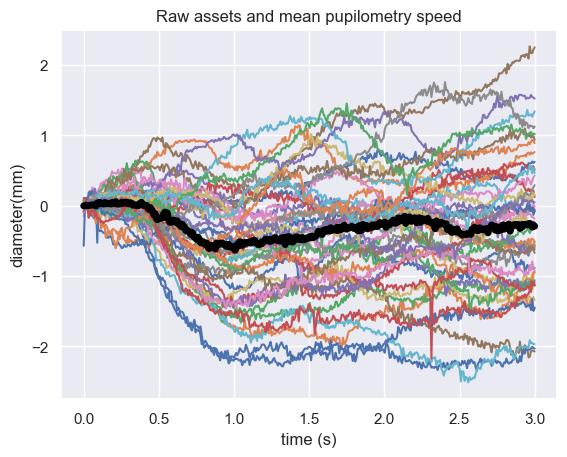

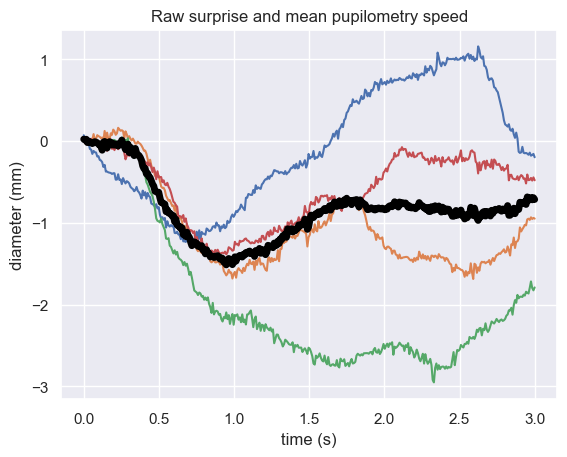

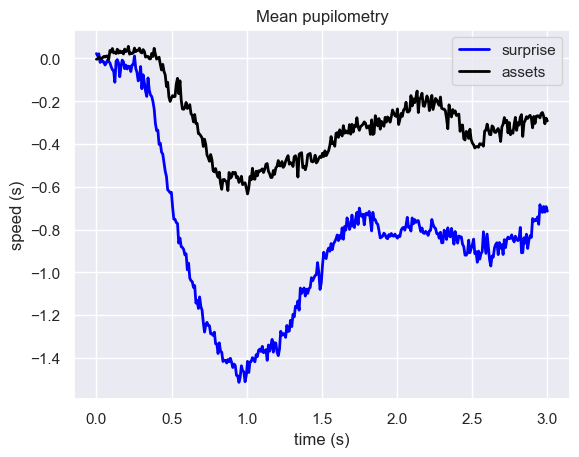

In [68]:
%matplotlib inline


mat=pupil_events_matrix
fig, ax=plt.subplots(1,1)
ax.plot(time_x,mat[window])
ax.plot(time_x,np.median(mat[window,:],axis=1),linewidth=5,color='black')
# ax.legend([images,'assets mean'])
ax.set_title('Raw assets and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('diameter(mm)')


mat=pupil_surprise_matrix
fig, ax=plt.subplots(1,1)
ax.plot(time_x,mat[window,:])
ax.plot(time_x,np.median(mat[window,:],axis=1),linewidth=5,color='black')
ax.set_title('Raw surprise and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('diameter (mm)')


fig, ax=plt.subplots(1,1)
ax.plot(time_x,np.median(pupil_surprise_matrix[window,:],axis=1),linewidth=2,color='blue')
ax.plot(time_x,np.median(pupil_events_matrix[window,:],axis=1),linewidth=2,color='black')

ax.legend(['surprise','assets'])
ax.set_title('Mean pupilometry')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (s)')

## Now lets calculate the speed of change from the normalized data

In [73]:

pupil_events_speed=np.abs(np.diff(pupil_events_matrix))
pupil_surprise_speed=np.abs(np.diff(pupil_surprise_matrix))

Text(0, 0.5, 'speed (s)')

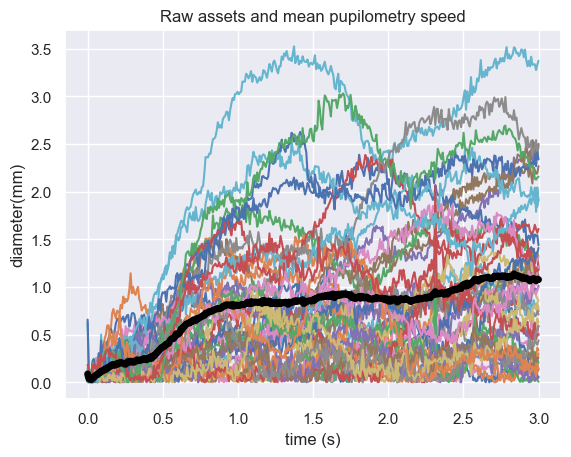

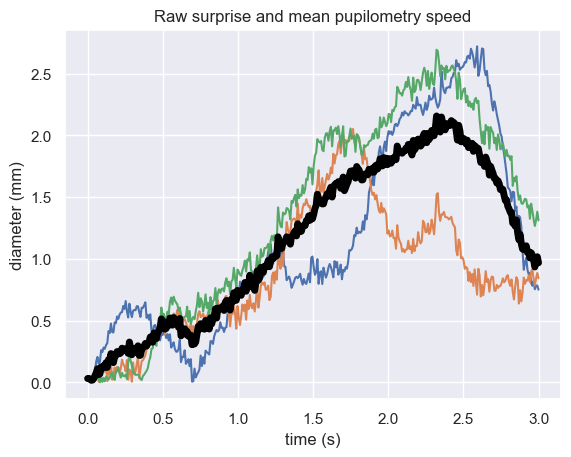

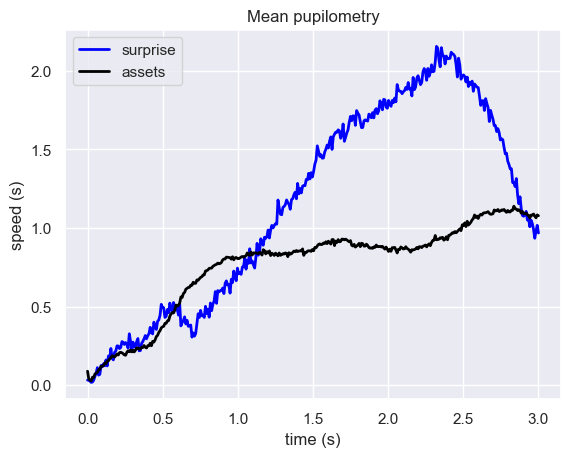

In [74]:
%matplotlib inline

mat1=pupil_events_speed
mat2=pupil_surprise_speed

fig, ax=plt.subplots(1,1)
ax.plot(time_x,mat1[window])
ax.plot(time_x,np.mean(mat1[window,:],axis=1),linewidth=5,color='black')
# ax.legend([images,'assets mean'])
ax.set_title('Raw assets and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('diameter(mm)')

fig, ax=plt.subplots(1,1)
ax.plot(time_x,mat2[window,:])
ax.plot(time_x,np.mean(mat2[window,:],axis=1),linewidth=5,color='black')
ax.set_title('Raw surprise and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('diameter (mm)')


fig, ax=plt.subplots(1,1)
ax.plot(time_x,np.mean(mat2[window,:],axis=1),linewidth=2,color='blue')
ax.plot(time_x,np.mean(mat1[window,:],axis=1),linewidth=2,color='black')

ax.legend(['surprise','assets'])
ax.set_title('Mean pupilometry')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (s)')

Exclude data that is over [2,-2] z scores


NameError: name 'pupil_zscore' is not defined

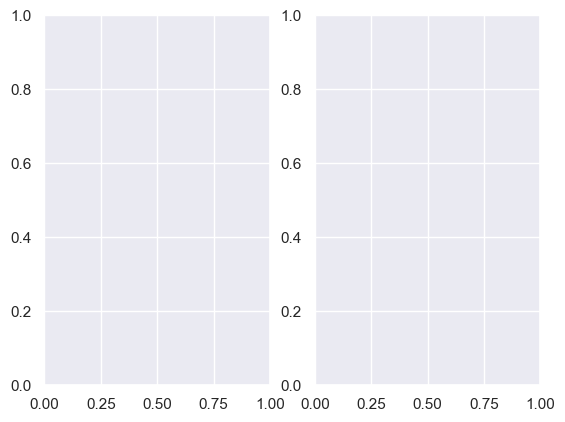

In [35]:
fig,ax=plt.subplots(1,2)
sns.histplot(pupil_zscore[window,6],ax=ax[0])
sns.histplot(pupil_events_matrix[window,6],ax=ax[1])

In [ ]:
#test sfuntion
sigma=1
mu=10
data_normal=sigma*np.random.randn(70,100) +mu
data_norm=nm.normalize(values=data_normal.reshape(data_normal.size),
                                            type='z_score').reshape(data_normal.shape)
plt.plot(data_normal,'.',color='red')
plt.plot(data_norm,'.',color='blue')
plt.plot(data_normal-10,'.',color='green')


In [ ]:
plt.hist(data_normal)


In [ ]:
pupil_events_matrix.shape[0]

In [ ]:
r=a.reshape(pupil_events_matrix.shape)

In [ ]:
pupil_events_matrix.shape[0]*pupil_events_matrix.shape[1]

In [ ]:
pupil_events_matrix.shape

In [ ]:
# pupil_list=[]
# surface_list=[]
# ref_col=surfaces_pd_frame.columns.get_indexer(['gaze_timestamp'])[0]

# for row in range(20,200):#(surfaces_pd_frame.shape[0]-1):
#         ini_val=surfaces_pd_frame.iloc[row,ref_col]
#         end_value=surfaces_pd_frame.iloc[row+1,ref_col]
#         surface_row=surfaces_pd_frame.iloc[row:row+1]
#         # print(ini_val,end_value)
#         aux_pd_frame=cm.filter_rows_by_temporal_values(
#                 dataframe=pupil_pd_frame,
#                 time_column='pupil_timestamp',
#                 ini_value=ini_val,
#                 end_value=end_value
#                 )
#         aux_pd_frame.insert(0,'horizontal_index',row)
#         surface_row.insert(0,'horizontal_index',row)
#         # aux_pd_frame=aux_pd_frame.join(to_join,rsuffisx='sur_',how='cross')

#         pupil_list.append(aux_pd_frame)
#         surface_list.append(surface_row)
# # final_df=pd.concat(final_df,axis=0)
# # display(final_df)
        
# vert_stack=pd.concat(pupil_list,axis=0)
# horz_stack=pd.concat(surface_list,axis=0)
# vert_stack.head()
# final_df=[]
# for row,index in surfaces_pd_frame.iterrows():
#         ini_val=surfaces_pd_frame.iloc[row]['gaze_timestamp']
#         end_value=surfaces_pd_frame.iloc[row+1]['gaze_timestamp']
#         to_join=surfaces_pd_frame.iloc[row:row+1]
#         # print(ini_val,end_value)
#         aux_pd_frame=cm.filter_rows_by_temporal_values(
#                 dataframe=pupil_pd_frame,
#                 time_column='pupil_timestamp',
#                 ini_value=ini_val,
#                 end_value=end_value
#                 )

#         # aux_pd_frame=aux_pd_frame.join(to_join,rsuffix='sur_',how='cross')
#         final_df.append(aux_pd_frame)
# # final_df=pd.concat(final_df,axis=0)
# # display(final_df)


In [101]:
import pandas as pd

data1 = {'price': ['computer', 'tablet', 'monitor', 'printer'],
         'brand': ['AA', 'BB', 'CC', 'DD'],
         'product': [1200, 350, 500, 150]
         }

df1 = pd.DataFrame(data1)


data2 = {'product': ['keyboard', 'mouse', 'speakers', 'scanner'],
         'brand': ['EE', 'FF', 'GG', 'HH'],
         'price': [120, 50, 200, 180]
         }

df2 = pd.DataFrame(data2)

union_dfs = pd.concat([df1, df2])
print(union_dfs)


      price brand   product
0  computer    AA      1200
1    tablet    BB       350
2   monitor    CC       500
3   printer    DD       150
0       120    EE  keyboard
1        50    FF     mouse
2       200    GG  speakers
3       180    HH   scanner


In [104]:
df1


,price,brand,product
0,computer,AA,1200
1,tablet,BB,350
2,monitor,CC,500
3,printer,DD,150


In [105]:
df2

,product,brand,price
0,keyboard,EE,120
1,mouse,FF,50
2,speakers,GG,200
3,scanner,HH,180
